In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# File path
file_path = r"C:\Users\ksama\Desktop\ev_data_normalized.csv"

# Load dataset
data = pd.read_csv(file_path)

In [2]:
# Define target column and features to drop
target_column = 'Electric Vehicle Type'


# Check if target column exists
if target_column not in data.columns:
    raise ValueError(f"Target column '{target_column}' not found in dataset.")

# Define features (X) and target (y)
X = data.drop(columns=target_column, errors='ignore')  # Drop unwanted columns
y = data[target_column] 


In [3]:
# Handle missing values in features
imputer = SimpleImputer(strategy="mean")  # Replace missing values with column mean
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Check class distribution in the target variable
print("Class Distribution in Target Variable:")
print(y.value_counts())

Class Distribution in Target Variable:
Electric Vehicle Type
0.0    174212
1.0     46013
Name: count, dtype: int64


In [4]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [6]:
# Define parameter sets for XGBoost and Neural Network
xgb_params = [
    {"max_depth": 3, "learning_rate": 0.1, "n_estimators": 50},
    {"max_depth": 5, "learning_rate": 0.05, "n_estimators": 100},
    {"max_depth": 7, "learning_rate": 0.01, "n_estimators": 200}
]

nn_params = [
    {"hidden_units": [64, 32], "learning_rate": 0.001, "epochs": 10},
    {"hidden_units": [128, 64], "learning_rate": 0.0005, "epochs": 15},
    {"hidden_units": [256, 128], "learning_rate": 0.0001, "epochs": 20}
]


=== Training Case 1 ===
Epoch 1/10
8713/8713 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.9662 - loss: 0.0873
Epoch 2/10
8713/8713 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9976 - loss: 0.0080
Epoch 3/10
8713/8713 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9982 - loss: 0.0066
Epoch 4/10
8713/8713 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9983 - loss: 0.0059
Epoch 5/10
8713/8713 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9984 - loss: 0.0057
Epoch 6/10
8713/8713 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9984 - loss: 0.0056
Epoch 7/10
8713/8713 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9984 - loss: 0.0057
Epoch 8/10
8713/8713 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9985 - loss: 0.0051
Epoch 9/10
8713/8713 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9986 - loss: 0.0050
Epoch 10/10
8713/8713 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9985 - loss: 0.0051
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Case 1 Results:
XGBoost Accuracy: 0.9964

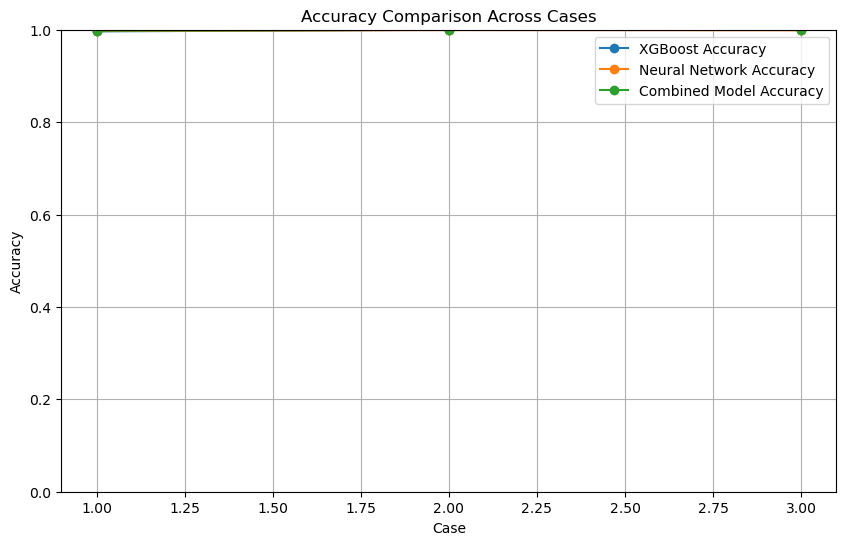

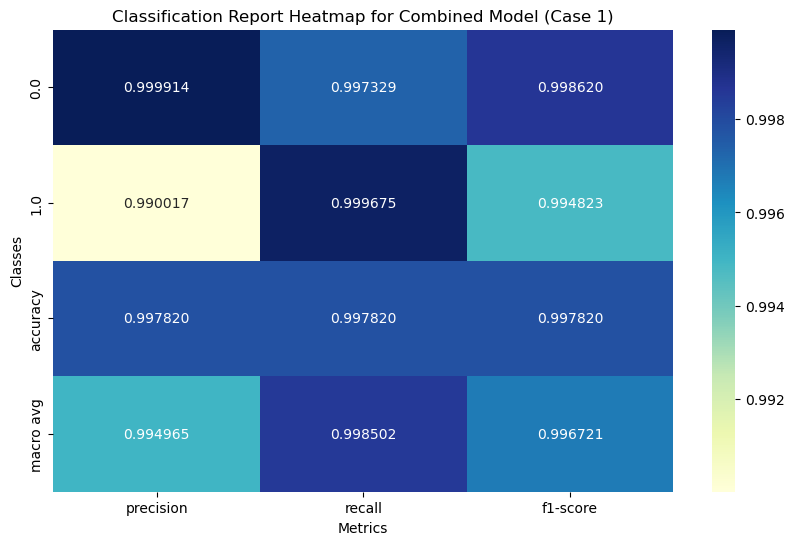

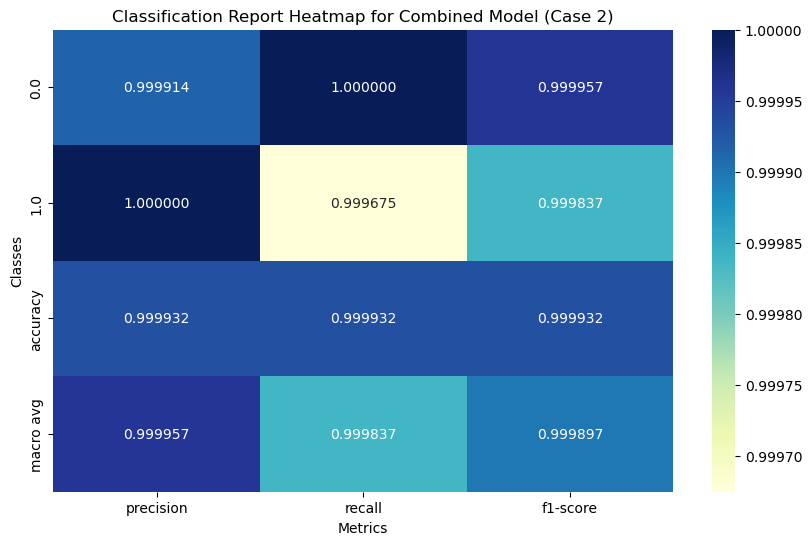

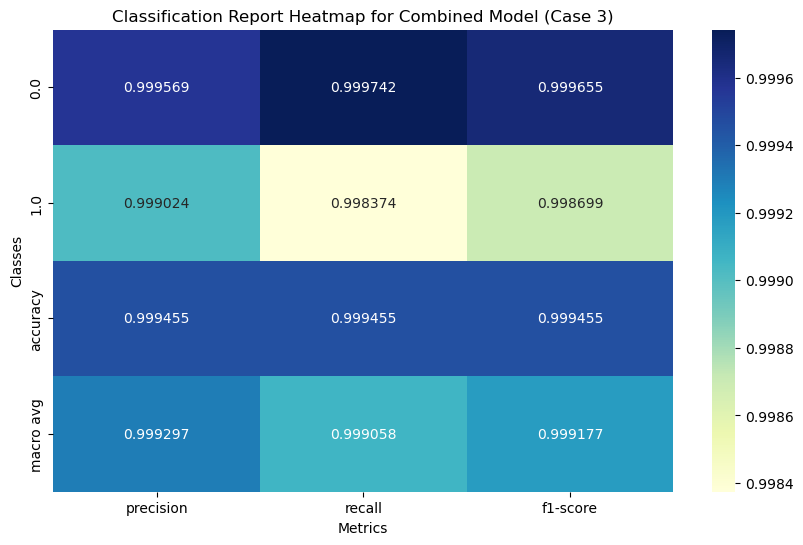

In [7]:
# Initialize results
results = []

# Loop through parameter sets
for i, (xgb_param, nn_param) in enumerate(zip(xgb_params, nn_params)):
    print(f"\n=== Training Case {i + 1} ===")
    
    # Train XGBoost model with current parameters
    class_ratio = y_train_balanced.value_counts()
    scale_pos_weight = class_ratio[0] / class_ratio[1]

    xgb_model = XGBClassifier(
        max_depth=xgb_param["max_depth"],
        learning_rate=xgb_param["learning_rate"],
        n_estimators=xgb_param["n_estimators"],
        scale_pos_weight=scale_pos_weight,
        eval_metric="logloss",
        random_state=42
    )
    xgb_model.fit(X_train_balanced, y_train_balanced)
    y_pred_xgb = xgb_model.predict(X_test)
    
      # Select important features using XGBoost
    selector = SelectFromModel(xgb_model, prefit=True, threshold="median")
    selected_features = X_train.columns[selector.get_support()]  # Preserve feature names
    X_train_selected = X_train_balanced[selected_features]
    X_test_selected = X_test[selected_features]
    
      # Define and train Neural Network with current parameters
    nn_model = Sequential()
    nn_model.add(Input(shape=(X_train_selected.shape[1],)))
    for units in nn_param["hidden_units"]:
        nn_model.add(Dense(units, activation='relu'))
    nn_model.add(Dense(1, activation='sigmoid'))  # Binary classification


    # Compute class weights for Neural Network
    class_weights = compute_class_weight("balanced", classes=np.unique(y_train_balanced), y=y_train_balanced)
    class_weights_dict = dict(enumerate(class_weights))

    # Compile the Neural Network
    nn_model.compile(optimizer=Adam(learning_rate=nn_param["learning_rate"]), 
                     loss='binary_crossentropy', 
                     metrics=['accuracy'])

   # Train Neural Network
    nn_model.fit(X_train_selected, y_train_balanced, epochs=nn_param["epochs"], batch_size=32, verbose=1, class_weight=class_weights_dict)
    y_pred_nn = (nn_model.predict(X_test_selected) > 0.5).astype(int)

    # Combine predictions from XGBoost and Neural Network
    combined_pred = (y_pred_xgb + y_pred_nn.flatten()) / 2
    final_pred = (combined_pred > 0.5).astype(int)

    # Evaluate models and store results
    xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
    nn_accuracy = accuracy_score(y_test, y_pred_nn)
    combined_accuracy = accuracy_score(y_test, final_pred)

    print(f"\nCase {i + 1} Results:")
    print(f"XGBoost Accuracy: {xgb_accuracy:.6f}")
    print(f"Neural Network Accuracy: {nn_accuracy:.6f}")
    print(f"Combined Model Accuracy: {combined_accuracy:.6f}")
    
    # Store classification reports
    results.append({
        "Case": i + 1,
        "XGBoost Parameters": xgb_param,
        "Neural Network Parameters": nn_param,
        "XGBoost Accuracy": xgb_accuracy,
        "Neural Network Accuracy": nn_accuracy,
        "Combined Model Accuracy": combined_accuracy,
        "XGBoost Report": classification_report(y_test, y_pred_xgb, digits=6, zero_division=0, output_dict=True),
        "Neural Network Report": classification_report(y_test, y_pred_nn, digits=6, zero_division=0, output_dict=True),
        "Combined Model Report": classification_report(y_test, final_pred, digits=6, zero_division=0, output_dict=True)
    })

# Consolidate results into a DataFrame
results_df = pd.DataFrame(results, columns=["Case", "XGBoost Parameters", "Neural Network Parameters",
                                            "XGBoost Accuracy", "Neural Network Accuracy",
                                            "Combined Model Accuracy"])

print("\n=== Summary Results ===")
print(results_df)

# Save results to a CSV
results_df.to_csv("hybrid_model_results.csv", index=False)
print("\nResults saved to 'hybrid_model_results.csv'")

# Visualize Accuracies
plt.figure(figsize=(10, 6))
cases = results_df["Case"]
plt.plot(cases, results_df["XGBoost Accuracy"], marker="o", label="XGBoost Accuracy")
plt.plot(cases, results_df["Neural Network Accuracy"], marker="o", label="Neural Network Accuracy")
plt.plot(cases, results_df["Combined Model Accuracy"], marker="o", label="Combined Model Accuracy")
plt.title("Accuracy Comparison Across Cases")
plt.xlabel("Case")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

# Visualize Classification Reports for Combined Model (Heatmap)
for i, result in enumerate(results):
    combined_report = pd.DataFrame(result["Combined Model Report"]).transpose()
    plt.figure(figsize=(10, 6))
    sns.heatmap(combined_report.iloc[:-1, :-1], annot=True, fmt=".6f", cmap="YlGnBu")
    plt.title(f"Classification Report Heatmap for Combined Model (Case {i + 1})")
    plt.xlabel("Metrics")
    plt.ylabel("Classes")
    plt.show()



Confusion Matrices for Case 1:


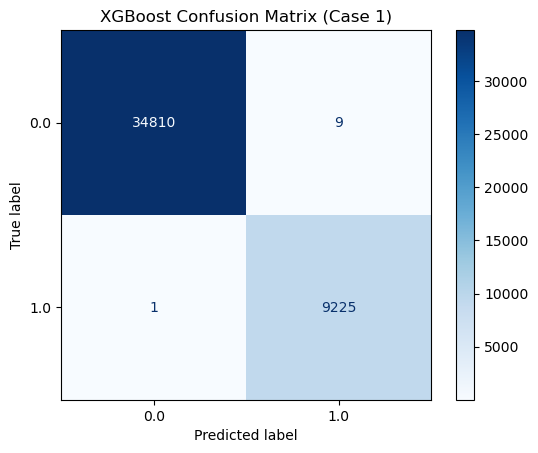

1377/1377 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


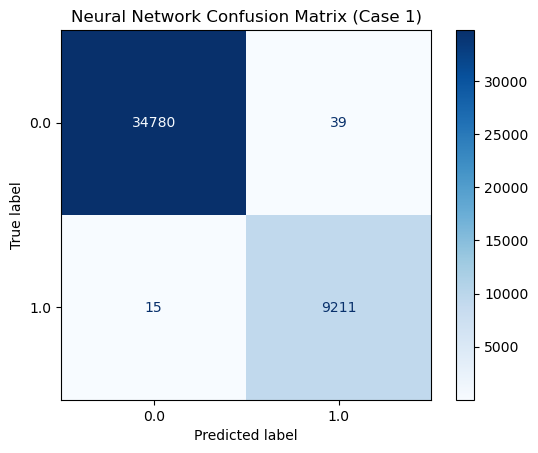

1377/1377 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


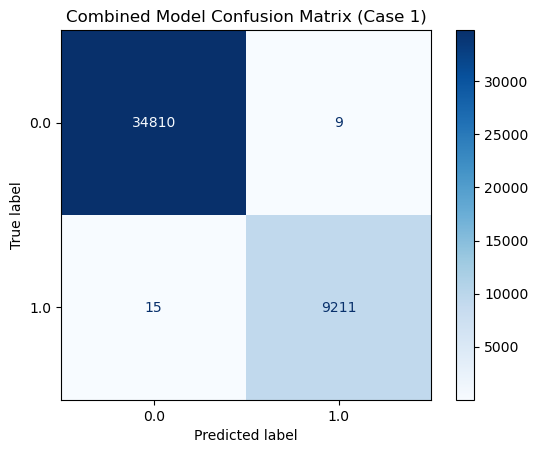


Confusion Matrices for Case 2:


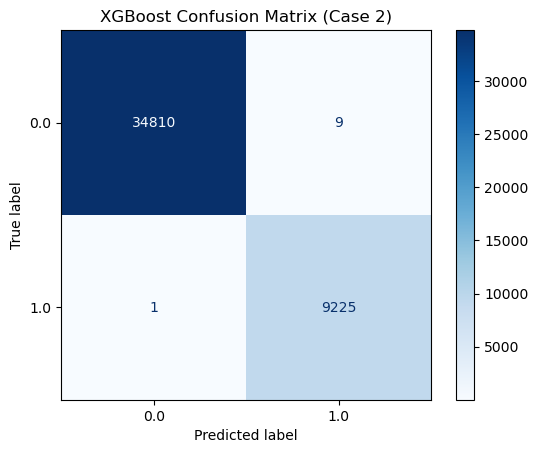

1377/1377 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


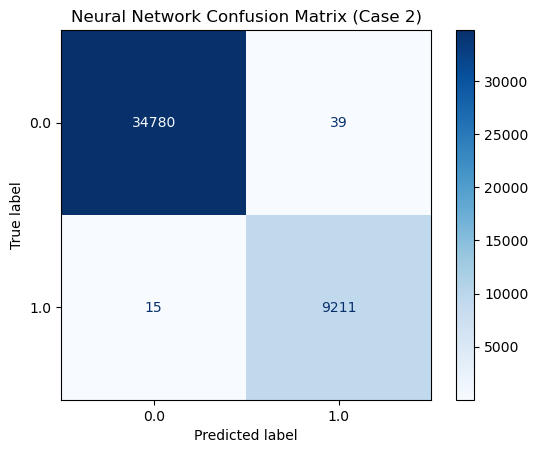

1377/1377 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


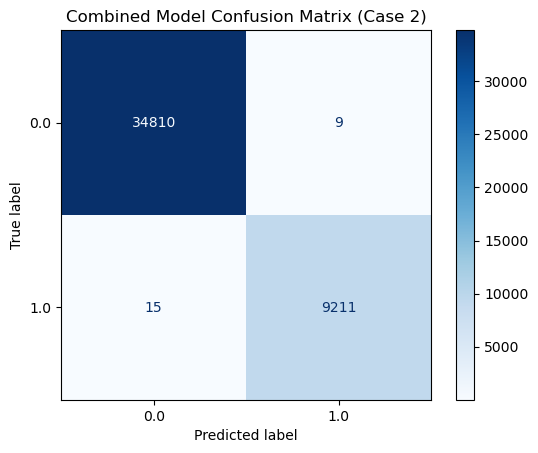


Confusion Matrices for Case 3:


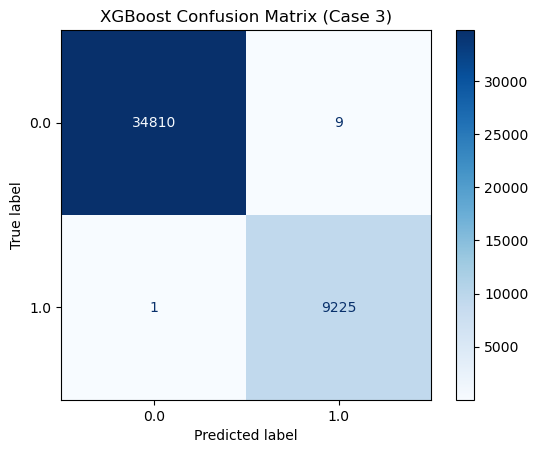

1377/1377 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


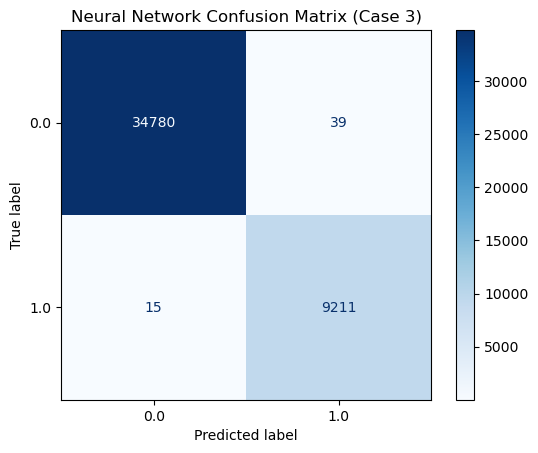

1377/1377 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


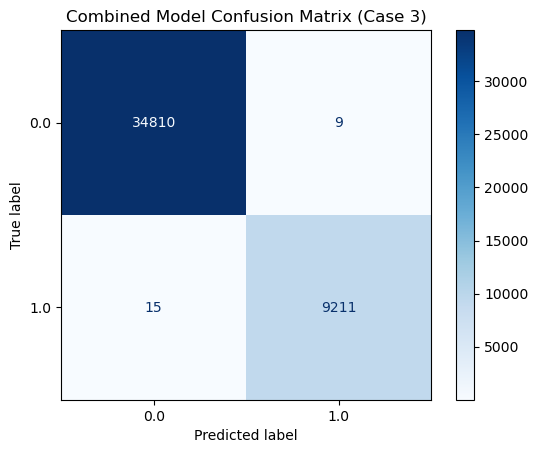

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for result in results:
    case_number = result["Case"]
    print(f"\nConfusion Matrices for Case {case_number}:")

    # XGBoost Confusion Matrix
    conf_matrix_xgb = confusion_matrix(y_test, xgb_model.predict(X_test))
    disp_xgb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_xgb, display_labels=np.unique(y_test))
    disp_xgb.plot(cmap="Blues", values_format="d")
    plt.title(f"XGBoost Confusion Matrix (Case {case_number})")
    plt.show()

    # Neural Network Confusion Matrix
    conf_matrix_nn = confusion_matrix(y_test, (nn_model.predict(X_test_selected) > 0.5).astype(int).flatten())
    disp_nn = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_nn, display_labels=np.unique(y_test))
    disp_nn.plot(cmap="Blues", values_format="d")
    plt.title(f"Neural Network Confusion Matrix (Case {case_number})")
    plt.show()

    # Combined Model Confusion Matrix
    combined_pred = (xgb_model.predict(X_test) + (nn_model.predict(X_test_selected) > 0.5).astype(int).flatten()) / 2
    final_pred = (combined_pred > 0.5).astype(int)
    conf_matrix_combined = confusion_matrix(y_test, final_pred)
    disp_combined = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_combined, display_labels=np.unique(y_test))
    disp_combined.plot(cmap="Blues", values_format="d")
    plt.title(f"Combined Model Confusion Matrix (Case {case_number})")
    plt.show()


In [9]:
# Consolidate classification reports for all cases into a single DataFrame for better visualization
classification_reports = []

for result in results:
    case_number = result["Case"]
    xgb_report = pd.DataFrame(result["XGBoost Report"]).transpose()
    nn_report = pd.DataFrame(result["Neural Network Report"]).transpose()
    combined_report = pd.DataFrame(result["Combined Model Report"]).transpose()

    classification_reports.append({
        "Case": f"Case {case_number} - XGBoost",
        "Report": xgb_report
    })
    classification_reports.append({
        "Case": f"Case {case_number} - Neural Network",
        "Report": nn_report
    })
    classification_reports.append({
        "Case": f"Case {case_number} - Combined Model",
        "Report": combined_report
    })

# Display all classification reports for each case
for report in classification_reports:
    case_name = report["Case"]
    report_df = report["Report"]
    print(f"\n--- {case_name} ---")
    print(report_df)



--- Case 1 - XGBoost ---
              precision    recall  f1-score       support
0.0            0.999913  0.995548  0.997726  34819.000000
1.0            0.983472  0.999675  0.991507   9226.000000
accuracy       0.996413  0.996413  0.996413      0.996413
macro avg      0.991693  0.997612  0.994617  44045.000000
weighted avg   0.996469  0.996413  0.996423  44045.000000

--- Case 1 - Neural Network ---
              precision    recall  f1-score       support
0.0            0.999971  0.996467  0.998216  34819.000000
1.0            0.986842  0.999892  0.993324   9226.000000
accuracy       0.997185  0.997185  0.997185      0.997185
macro avg      0.993407  0.998180  0.995770  44045.000000
weighted avg   0.997221  0.997185  0.997191  44045.000000

--- Case 1 - Combined Model ---
              precision    recall  f1-score      support
0.0            0.999914  0.997329  0.998620  34819.00000
1.0            0.990017  0.999675  0.994823   9226.00000
accuracy       0.997820  0.997820  0.9978

In [10]:
def simplified_nn_diagram(input_nodes, hidden_units, output_nodes):
    """
    Simplified visualization of a neural network diagram.
    Displays layers with increased distance between nodes and connections.
    """
    layer_sizes = [input_nodes] + hidden_units + [output_nodes]
    layer_labels = ["Input"] + [f"Hidden {i+1}" for i in range(len(hidden_units))] + ["Output"]

    plt.figure(figsize=(12, 6))  # Increase figure size for better visibility
    
    # Scaling factors for spacing
    x_spacing = 100  # Distance between layers
    y_spacing = 100 # Distance between nodes in a layer

    # Position each layer along the x-axis
    for i, size in enumerate(layer_sizes):
        x = i * x_spacing
        y_positions = [j * y_spacing for j in range(-size // 2, size // 2)]  # Spread nodes vertically
        plt.scatter([x] * size, y_positions, s=200, label=layer_labels[i], zorder=3)

        # Draw connections
        if i < len(layer_sizes) - 1:
            next_size = layer_sizes[i + 1]
            next_y_positions = [j * y_spacing for j in range(-next_size // 2, next_size // 2)]
            for y in y_positions:
                for ny in next_y_positions:
                    plt.plot([x, x + x_spacing], [y, ny], color="gray", lw=0.7, zorder=1)

    plt.title("Simplified Neural Network Diagram with Enlarged Spacing", fontsize=14)
    plt.axis("off")
    plt.legend(loc="upper right", fontsize=10)
    plt.show()


Creating simplified diagram for NN with hidden units: [64, 32]
The input layers are:6


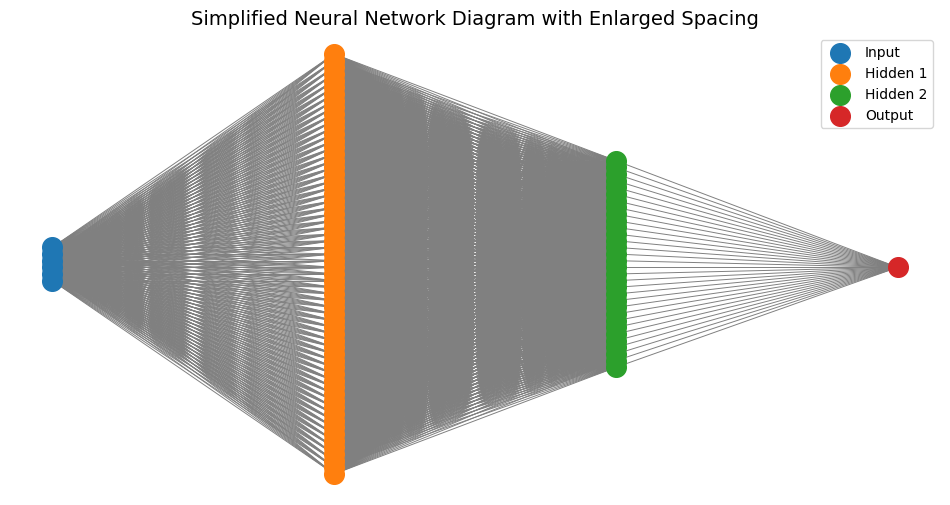

Creating simplified diagram for NN with hidden units: [128, 64]
The input layers are:6


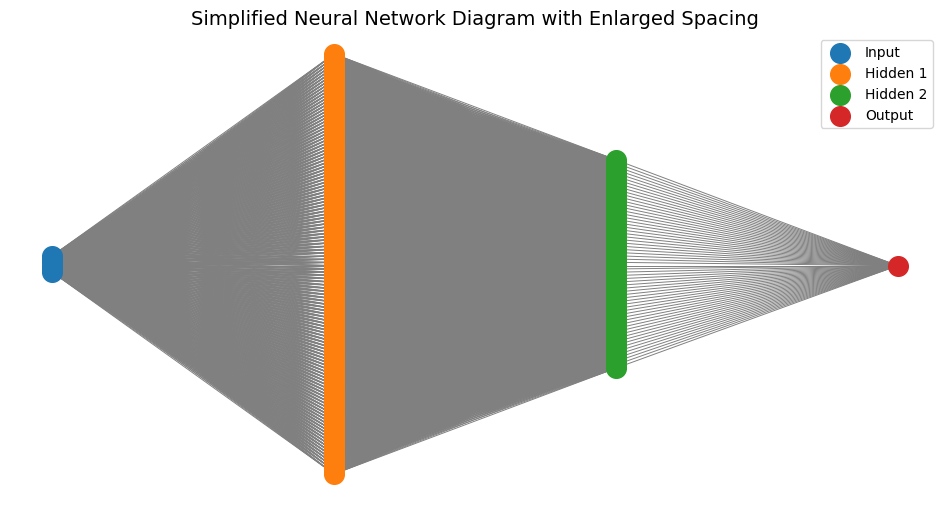

Creating simplified diagram for NN with hidden units: [256, 128]
The input layers are:6


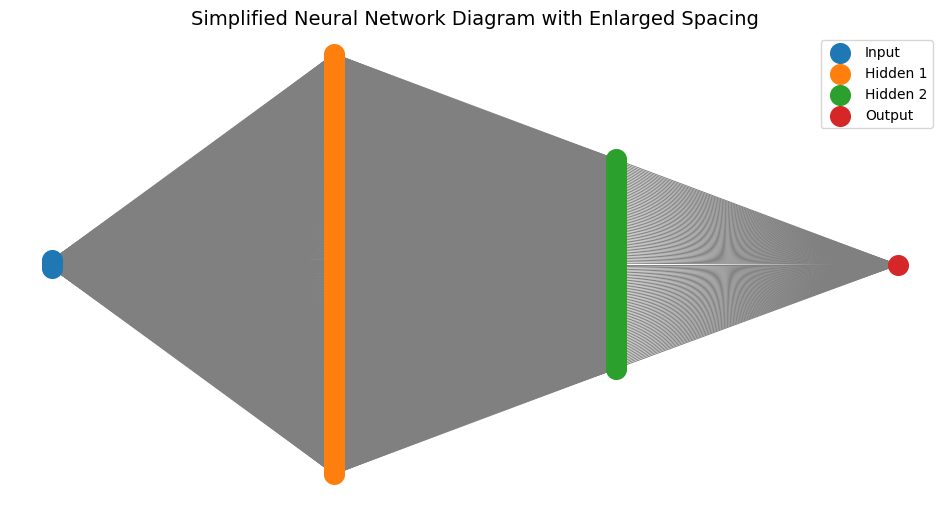

In [11]:
# Set the number of input nodes dynamically
input_nodes = X_train_selected.shape[1]  # Number of selected features

# Set the number of output nodes dynamically
# Assuming binary classification
output_nodes = 1  # For binary classification

# Create simplified diagrams for the configurations
for config in nn_params:
    print(f"Creating simplified diagram for NN with hidden units: {config['hidden_units']}")
    print(f"The input layers are:{input_nodes}")
    simplified_nn_diagram(input_nodes, config["hidden_units"], output_nodes)
